In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
from plotly import express as px

pd.set_option("display.max_rows",100)

In [2]:
data = pd.read_csv("municipality_bus_utilization.csv")
data["timestamp"] = pd.to_datetime(data["timestamp"])
data.set_index("timestamp", inplace=True)
munip_dict = {i:f"munip_{i}" for i in data["municipality_id"].unique()}
data["municipality_id"].replace(munip_dict, inplace=True)

# Analysis & Preprocessing

In [3]:
data.isna().sum()

municipality_id    0
usage              0
total_capacity     0
dtype: int64

In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
usage,13070.0,876.002984,679.287109,11.0,403.0,692.0,1190.0,3508.0
total_capacity,13070.0,1972.800000,1144.074782,397.0,697.0,1974.5,2947.0,3893.0


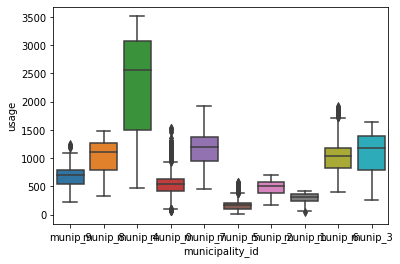

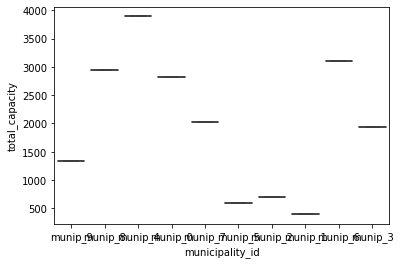

In [5]:
sns.boxplot(data=data, x="municipality_id", y="usage")
plt.show()
sns.boxplot(data=data, x="municipality_id", y="total_capacity")
plt.show()

capacities are not dynamic

In [6]:
id = 1
munip = munip_dict[id]
data_w_id = data[data["municipality_id"]==munip]

fig = go.Figure()

fig.add_trace(go.Scatter(x=data_w_id.index,
                    y=data_w_id["usage"],
                    name="usage",
                    mode='markers'))

fig.add_trace(go.Scatter(x=data_w_id.index,
                    y=data_w_id["total_capacity"],
                    name="total_capacity",
                    mode='markers'))

In some of the municipalities, usage exceeds total_capacity. How?

There are clear cyclic motions, sin functions can be applied in feature eng.

In [7]:
data.groupby(by=["municipality_id"]).agg({"usage":"count"})
# All munips have the same number of data points

,usage
municipality_id,
munip_0,1307
munip_1,1307
munip_2,1307
munip_3,1307
munip_4,1307
munip_5,1307
munip_6,1307
munip_7,1307
munip_8,1307


<AxesSubplot:xlabel='municipality_id', ylabel='municipality_id'>

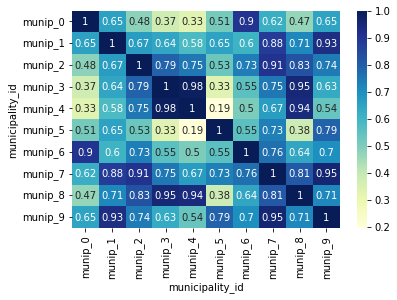

In [8]:
corr_mat = data.pivot_table("usage", data.index, data["municipality_id"]).corr()
sns.heatmap(corr_mat, cmap="YlGnBu", annot=True)

No negative correlations!

/var/folders/_l/048d7_xs4nq8m4g2753wq9bc0000gn/T/ipykernel_91600/627684728.py:3: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



<AxesSubplot:xlabel='timestamp', ylabel='usage'>

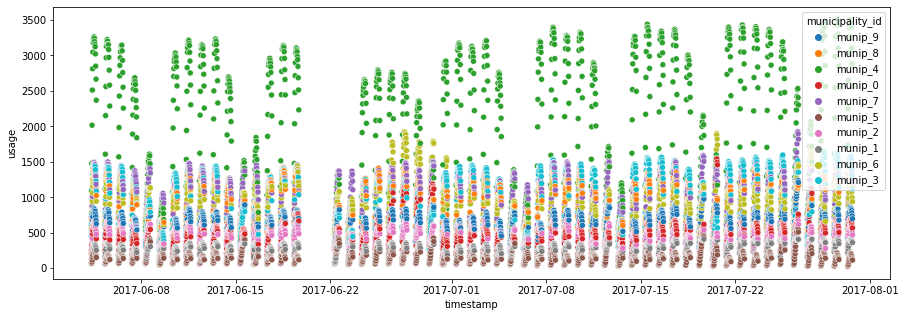

In [9]:
plt.figure(figsize=(15,5))

sns.scatterplot(data=data.loc["2017-06":"2017-07",:], x=data.loc["2017-06":"2017-07",:].index, y="usage", hue="municipality_id")

In [10]:
grouped_df = data.groupby(by=["municipality_id",pd.Grouper(freq="D")]).count()
grouped_df[grouped_df["usage"]!=18]

usage  total_capacity
municipality_id timestamp                        
munip_0         2017-06-28     17              17
                2017-06-30     34              34
                2017-07-18     17              17
                2017-07-25     17              17
                2017-08-13     17              17
                2017-08-14     17              17
munip_1         2017-06-28     17              17
                2017-06-30     34              34
                2017-07-18     17              17
                2017-07-25     17              17
                2017-08-13     17              17
                2017-08-14     17              17
munip_2         2017-06-28     17              17
                2017-06-30     34              34
                2017-07-18     17              17
                2017-07-25     17              17
                2017-08-13     17              17
                2017-08-14     17              17
munip_3         2017-06-28     17              17
                2017-06-30     34              34
                2017-07-18     17              17
                2017-07-25     17              17
                2017-08-13     17              17
                2017-08-14     17              17
munip_4         2017-06-28     17              17
                2017-06-30     34              34
                2017-07-18     17              17
                2017-07-25     17              17
                2017-08-13     17              17
                2017-08-14     17              17
munip_5         2017-06-28     17              17
                2017-06-30     34              34
                2017-07-18     17              17
                2017-07-25     17              17
                2017-08-13     17              17
                2017-08-14     17              17
munip_6         2017-06-28     17              17
                2017-06-30     34              34
                2017-07-18     17              17
                2017-07-25     17              17
                2017-08-13     17              17
                2017-08-14     17              17
munip_7         2017-06-28     17              17
                2017-06-30     34              34
                2017-07-18     17              17
                2017-07-25     17              17
                2017-08-13     17              17
                2017-08-14     17              17
munip_8         2017-06-28     17              17
                2017-06-30     34              34
                2017-07-18     17              17
                2017-07-25     17              17
                2017-08-13     17              17
                2017-08-14     17              17
munip_9         2017-06-28     17              17
                2017-06-30     34              34
                2017-07-18     17              17
                2017-07-25     17              17
                2017-08-13     17              17
                2017-08-14     17              17

There are different numbers of observ. in each day for each munip.

In [11]:
data_hourly = data.groupby(by=["municipality_id",pd.Grouper(freq="H")]).agg({"usage":"max"})
data_hourly.reset_index(inplace=True)
data_hourly.set_index("timestamp", inplace=True)
# data is grouped by "municipality_id" and frequency(hour) -> max of each hour is extracted

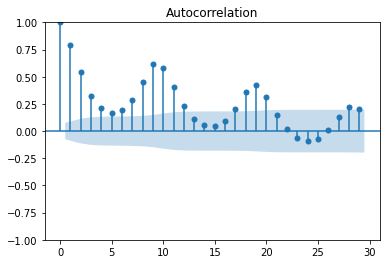

In [12]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_hourly[data_hourly["municipality_id"]=="munip_0"]["usage"], missing="drop");
# Checked cyclic motion hypotesis

In [13]:
pivot_wh = pd.DataFrame(index=pd.date_range(data_hourly.index.min(), (data_hourly.index.max()+pd.Timedelta(days=7)), freq="H") ,columns=data_hourly["municipality_id"].unique())
pivot_wh = pivot_wh[(pivot_wh.index.hour>=7) & (pivot_wh.index.hour<=16)]
pivot_wh.reset_index(inplace=True)
pivot_wh.rename(columns={"index":"date"}, inplace=True)
# A Pivot Table that consists of whole dates (with NaN values) is created

data_hourly_wh = pivot_wh.melt(id_vars=["date"], var_name="municipality_id", value_name="usage")
data_hourly_wh.set_index("date", inplace=True)
# Pivot Table converted to DataFrame

data_hourly_wh = pd.merge(data_hourly_wh.reset_index().drop(columns=["usage"]), data_hourly.reset_index(), left_on=["date","municipality_id"], right_on=["timestamp","municipality_id"], how="left")
data_hourly_wh.set_index("date", inplace=True)
data_hourly_wh.drop(columns=["timestamp"], inplace=True)
# Merged with filled data

In [14]:
poss_test = data_hourly_wh["2017-08-05":"2017-08-19"].copy()
poss_test[poss_test["usage"].isna()].head()
# In test data, at 7 o'clock, usgage values are "NaN
# In those days are imputed thorugh training data it will cause leakage and bias towards training data
# Thus, I detemine to not use to 7'oclock data 

/var/folders/_l/048d7_xs4nq8m4g2753wq9bc0000gn/T/ipykernel_91600/192285382.py:1: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



,municipality_id,usage
date,,
2017-08-05 07:00:00,munip_0,NaN
2017-08-09 07:00:00,munip_0,NaN
2017-08-11 07:00:00,munip_0,NaN
2017-08-12 07:00:00,munip_0,NaN
2017-08-13 07:00:00,munip_0,NaN


In [15]:
# Removed 7oclock from all hourly data
data_hourly_wh = data_hourly_wh[(data_hourly_wh.index.hour>=8) & (data_hourly_wh.index.hour<=16)].copy()

In [16]:
data_hourly.shape, data_hourly_wh.shape

((6740, 2), (7560, 2))

In [17]:
# Small class is created for make data manipulations easily
class PI_works:
    def __init__(self, df, munip_dict):
        self.all_data = df

        self.train_range = ["2017-06-04","2017-08-04"]
        self.test_range1 = ["2017-08-05","2017-08-11"]
        self.test_range2 = ["2017-08-12","2017-08-19"]
        self.oob_range = ["2017-08-20","2017-08-26"]

        self.train_data = df.loc[self.train_range[0]:self.train_range[1]]
        self.test_data1 = df.loc[self.test_range1[0]:self.test_range1[1]]
        self.test_data2 = df.loc[self.test_range2[0]:self.test_range2[1]]
        self.obb_data = df.loc[self.oob_range[0]:self.oob_range[1]]

    def get_munip_f_hourly(self, munip_id):
        munip = munip_dict[munip_id]
        return self.all_data[self.all_data["municipality_id"]==munip]

    def pivot_data(self):
        return self.all_data.pivot_table(values="usage", index=self.all_data.index, columns=self.all_data["municipality_id"],dropna=False)        

    def get_munip_f_pivot(self, munip_id):
        munip = munip_dict[munip_id]
        pivotted = self.pivot_data()        
        return pivotted[[munip]]
    
    @staticmethod
    def datetime_features(dataframe):
        dataframe['month'] = dataframe.index.dt.month
        dataframe['hour'] = dataframe.index.dt.hour
        dataframe['dayofweek'] = dataframe.index.dt.dayofweek
        dataframe['dayofmonth'] = dataframe.index.dt.day
        dataframe['weekofyear'] = dataframe.index.dt.weekofyear
        return dataframe

In [18]:
PW = PI_works(data_hourly_wh, munip_dict)

/var/folders/_l/048d7_xs4nq8m4g2753wq9bc0000gn/T/ipykernel_91600/75134587.py:11: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.

/var/folders/_l/048d7_xs4nq8m4g2753wq9bc0000gn/T/ipykernel_91600/75134587.py:12: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.

/var/folders/_l/048d7_xs4nq8m4g2753wq9bc0000gn/T/ipykernel_91600/75134587.py:13: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.

/var/folders/_l/048d7_xs4nq8m4g2753wq9bc0000gn/T/ipykernel_91600/75134587.py:14: FutureWarning:

Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.



# Imputation

In [19]:
PW.pivot_data()

municipality_id,munip_0,munip_1,munip_2,munip_3,munip_4,munip_5,munip_6,munip_7,munip_8,munip_9
date,,,,,,,,,,
2017-06-04 08:00:00,332.0,164.0,355.0,967.0,2016.0,89.0,801.0,873.0,857.0,527.0
2017-06-04 09:00:00,485.0,245.0,494.0,1263.0,2811.0,159.0,1061.0,1151.0,1172.0,666.0
2017-06-04 10:00:00,583.0,317.0,582.0,1396.0,3178.0,228.0,1219.0,1373.0,1363.0,800.0
2017-06-04 11:00:00,614.0,341.0,643.0,1456.0,3257.0,268.0,1297.0,1479.0,1399.0,845.0
2017-06-04 12:00:00,613.0,343.0,657.0,1469.0,3260.0,275.0,1306.0,1493.0,1406.0,845.0
...,...,...,...,...,...,...,...,...,...,...
2017-08-26 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-26 13:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-08-26 14:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
PW.get_munip_f_pivot(0).groupby(by=pd.Grouper(freq="D")).count()
# 9 obs. in one day expect "nan" days

municipality_id,munip_0
date,
2017-06-04,9
2017-06-05,9
2017-06-06,9
2017-06-07,9
2017-06-08,9
2017-06-09,9
2017-06-10,9
2017-06-11,9
2017-06-12,9


In [21]:
# testing impuation techniques with one of the municipilities
pivot_0 = PW.get_munip_f_pivot(0).copy()
pivot_0_tr = pivot_0.loc[PW.train_range[0]:PW.train_range[1]].copy()

In [22]:
from statsmodels.tsa.arima.model import ARIMA
arima_model = ARIMA(pivot_0_tr["munip_0"], order=(9,0,3))
model = arima_model.fit()
pivot_0_tr["arima_imp"] = model.predict(0)
# A very simple method (ARIMA(9,0,0)) applied and parameters are not tuned to decrase variablitiy 
# and bias towards to final model which will be tuned

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [23]:
from sklearn.metrics import r2_score, mean_absolute_percentage_error
non_nan_index = pivot_0_tr[~pivot_0_tr["munip_0"].isna()].index
print("r2: ", r2_score(pivot_0_tr.loc[non_nan_index]["munip_0"], pivot_0_tr.loc[non_nan_index]["arima_imp"]))
print("MAPE: ", mean_absolute_percentage_error(pivot_0_tr.loc[non_nan_index]["munip_0"], pivot_0_tr.loc[non_nan_index]["arima_imp"]))
mape_errors = np.abs(pivot_0_tr.loc[non_nan_index]["munip_0"] - pivot_0_tr.loc[non_nan_index]["arima_imp"])/pivot_0.loc[non_nan_index]["munip_0"]
# Scores in training data, 76% variablity is explanied

r2:  0.7439824366257071
MAPE:  0.18134770135563902


In [24]:
px.scatter(pivot_0_tr)
# By observing the predictions and real values, it is seen that simple AR(9) model able to captures the daily 
# cyclic behaviour

In [25]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=pivot_0_tr.index, y=pivot_0_tr["munip_0"], name="real_values", mode="markers+lines"))
# fig.add_trace(go.Scatter(x=pivot_0_tr.index, y=pivot_0_tr["arima_imp"], name="imputed_values", mode="markers"))

fig.add_trace(go.Scatter(x=mape_errors.index, y=mape_errors.values, name="errors", yaxis="y2", mode="markers"))

fig.update_layout(
    yaxis = {"title":"usage"},
    yaxis2 = {"title":"error", "overlaying":"y", "side":"right"}
)
# Also, errors and their locations are visually analyzed, it is seen that high percentage errors comes from higher 
# usage points

In [26]:
# In this code block every munipipilicities imputed seperately via its usage values wtih ARIMA model. Also the 
# ARIMA model that is used in imputation is also used as a baseline model
# Test scores are saved
pivot_data = PW.pivot_data().copy()
pivot_data_tr = pivot_data.loc[PW.train_range[0]:PW.train_range[1]].copy()

# imputation will be done with only training data to prevent leakage
pivot_data_te1 = pivot_data.loc[PW.test_range1[0]:PW.test_range1[1]].copy()
pivot_data_te2 = pivot_data.loc[PW.test_range2[0]:PW.test_range2[1]].copy()
pivot_data_oob = pivot_data.loc[PW.oob_range[0]:PW.oob_range[1]].copy()

non_nan_index = pivot_data_tr[~pivot_data_tr["munip_0"].isna()].index
nan_index = pivot_data_tr[pivot_data_tr["munip_0"].isna()].index

scores = {}
for col in pivot_data:
    arima_model = ARIMA(pivot_data_tr[col], order=(9,0,3))
    model = arima_model.fit()
    pred_col = f"{col}_pred"
    pivot_data_tr[pred_col] = model.predict()
    imp_col = f"{col}_imp"
    pivot_data_tr[imp_col] = pivot_data_tr[col]
    pivot_data_tr.loc[nan_index, imp_col] = pivot_data_tr.loc[nan_index, pred_col]
    c_r2 = r2_score(pivot_data_tr.loc[non_nan_index][col], pivot_data_tr.loc[non_nan_index][pred_col])
    c_mape_tr = mean_absolute_percentage_error(pivot_data_tr.loc[non_nan_index][col], pivot_data_tr.loc[non_nan_index][pred_col])
    c_mape_te1 = mean_absolute_percentage_error(pivot_data_te1[col], model.forecast(pivot_data_te1[col].shape[0]))
    c_mape_te2 = mean_absolute_percentage_error(pivot_data_te2[col], model.forecast(pivot_data_te2[col].shape[0]))
    scores[col] = {
                   "mape_tr_ARMA":c_mape_tr,
                   "mape_te1_ARMA":c_mape_te1,
                   "mape_te2_ARMA":c_mape_te2,
                   "tr_pred":pivot_data_tr.loc[non_nan_index][pred_col]
                   }

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/Library/Framewor

In [27]:
# Baseline score of imputation model.
baseline_scores = pd.DataFrame(scores)
baseline_scores

,munip_0,munip_1,munip_2,munip_3,munip_4,munip_5,munip_6,munip_7,munip_8,munip_9
mape_tr_ARMA,0.181348,0.107671,0.092216,0.134075,0.136764,0.291244,0.102363,0.079441,0.093459,0.084129
mape_te1_ARMA,0.162648,0.185929,0.169209,0.3109,0.335125,1.179787,0.137253,0.156331,0.234126,0.158169
mape_te2_ARMA,0.319246,0.183775,0.199099,0.307536,0.323037,1.124807,0.212719,0.168714,0.23523,0.162675
tr_pred,date 2017-06-04 08:00:00 545.179307 2017-06...,date 2017-06-04 08:00:00 299.111905 2017-06...,date 2017-06-04 08:00:00 495.778313 2017-06...,date 2017-06-04 08:00:00 1107.936942 2017-0...,date 2017-06-04 08:00:00 2357.844841 2017-0...,date 2017-06-04 08:00:00 183.401650 2017-06...,date 2017-06-04 08:00:00 1037.163125 2017-0...,date 2017-06-04 08:00:00 1167.210276 2017-0...,date 2017-06-04 08:00:00 1057.328237 2017-0...,date 2017-06-04 08:00:00 681.531174 2017-06...


In [28]:
# only imputed part of them is extracted
pivot_data_imp_tr = pivot_data_tr[[i for i in pivot_data_tr.columns if "imp" in i]].copy()
pivot_data_te1.columns = pivot_data_imp_tr.columns
pivot_data_te2.columns = pivot_data_imp_tr.columns
pivot_data_oob.columns = pivot_data_imp_tr.columns

pivot_data_imp = pd.concat([pivot_data_imp_tr, pivot_data_te1, pivot_data_te2, pivot_data_oob],axis=0)

# Model

## Feature Engineering

In [29]:
def lag_features(df_temp,
                 columns,
                 lags,
                 fh):
    """
    This function will create lag features with given columns and given periods
    """
    for col in columns:
        for lag in lags:
            df_temp[f'lag_{lag}_{col}'] = df_temp[col].shift(fh+lag)
    return df_temp

def rolling_features(df_temp,
                     columns,
                     rolls,
                     roll_types,
                     fh):  
    """
    This function will create rolling features with given columns, given periods, and given rolling types
    """
    for col in columns:
        for roll in rolls:
            if 'mean' in roll_types:
                df_temp[f'rolling_mean_{roll}_{col}'] = df_temp[col].rolling(fh+roll,min_periods=1).mean().reset_index(drop=True).values
            if 'max' in roll_types:
                df_temp[f'rolling_max_{roll}_{col}'] = df_temp[col].rolling(fh+roll,min_periods=1).max().reset_index(drop=True).values
            if 'min' in roll_types:
                df_temp[f'rolling_min_{roll}_{col}'] = df_temp[col].rolling(fh+roll,min_periods=1).min().reset_index(drop=True).values
            if 'std' in roll_types:
                df_temp[f'rolling_std_{roll}_{col}'] = df_temp[col].rolling(fh+roll,min_periods=1).std().reset_index(drop=True).values
    return df_temp

def datetime_features(df_temp):
    """
    This function will create date features as categorical variables
    """
    df_temp['hour_datef'] = df_temp.index.hour
    df_temp['dayofweek_datef'] = df_temp.index.dayofweek
    df_temp['weekend_datef'] = df_temp['dayofweek_datef'].apply(lambda x: 1 if x>=5 else 0)
    df_temp['dayofmonth_datef'] = df_temp.index.day
    return df_temp

def seasonality_features(df_temp):
    """
    This function will create sin waves in hour to capture cyclic behavior of usage
    """
    hours_norm = (df_temp.index.hour- 8)/16-8 *2*np.pi
    df_temp['hour_sin1'] = np.sin(hours_norm)
    df_temp['hour_cos1'] = np.cos(hours_norm)
    df_temp['hour_sin2'] = np.sin(hours_norm+0.2)
    df_temp['hour_cos2'] = np.cos(hours_norm+0.2)
    return df_temp

In [30]:
fh = int((PW.test_data1.shape[0]+PW.test_data2.shape[0])/10)
print(fh)
# forecast horizon: 15 days -> 135 hours

135


In [81]:
# checkpoint
# AA = pivot_data_imp.copy()
pivot_data_imp = AA.copy()

In [82]:
usage_cols = [i for i in pivot_data_imp.columns if "munip" in i]
capacities = data.groupby(by=["municipality_id"])[["total_capacity"]].mean()
util_cols = [i+"_utils" for i in pivot_data_imp.columns]
# pivot_data_imp[util_cols] = pivot_data_imp.values/capacities.T.values

In [83]:
# Adding features
pivot_data_imp = seasonality_features(pivot_data_imp).copy()
pivot_data_imp = datetime_features(pivot_data_imp).copy()
pivot_data_imp = lag_features(pivot_data_imp,
                columns=usage_cols,
                lags=[1,9],
                fh=fh).copy()

pivot_data_imp = rolling_features(df_temp=pivot_data_imp,
                    columns=usage_cols,
                    rolls=[9],
                    roll_types=["mean","std"],
                    fh=fh).copy()

# pivot_data_imp = rolling_features(df_temp=pivot_data_imp,
#                     columns=util_cols,
#                     rolls=[9],
#                     roll_types=["mean","std"],
#                     fh=fh).copy()

## Split

In [84]:
train_df = pivot_data_imp.loc[PW.train_range[0]:PW.train_range[1]]
train_df = train_df.iloc[fh+9:,:] # Lost points because of the rolling features at the start
test_df1 = pivot_data_imp.loc[PW.test_range1[0]:PW.test_range1[1]]
test_df2 = pivot_data_imp.loc[PW.test_range2[0]:PW.test_range2[1]]
oob_df = pivot_data_imp.loc[PW.oob_range[0]:PW.oob_range[1]]

y_trains = train_df.loc[:,usage_cols].copy()
y_tests1 = test_df1.loc[:,usage_cols].copy()
y_tests2 = test_df2.loc[:,usage_cols].copy()

X_train = train_df.drop(columns=usage_cols)
X_test1 = test_df1.drop(columns=usage_cols)
X_test2 = test_df2.drop(columns=usage_cols)

# X_train = train_df.drop(columns=usage_cols+util_cols)
# X_test1 = test_df1.drop(columns=usage_cols+util_cols)
# X_test2 = test_df2.drop(columns=usage_cols+util_cols)

## CatBoost

In [85]:
# In this codeblock, the best parameters searced with TimeSeriesSplit cross-validation for forecasting each
# of the municipiliy usage values
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from catboost import CatBoostRegressor

cv_summary = {}
tscv = TimeSeriesSplit(n_splits=2,test_size=fh)

for target in usage_cols: 
    cat_obj = []
    test_forecasts1 =[]
    test_forecasts2 =[]
    train_scores = []
    val_scores = []
    test_scores1 = []
    test_scores2 = []
    feature_importances = []
    fold = 0

    y_train = y_trains[target]
    y_test1 = y_tests1[target]
    y_test2 = y_tests2[target]
    print(f"CV for {target}\n")

    for train_index,val_index in tscv.split(X_train,y_train):
        print(f"Fold: {fold}")
        X_train_,X_val_ = X_train.iloc[train_index],X_train.iloc[val_index]
        y_train_,y_val_ = y_train.iloc[train_index],y_train.iloc[val_index]

        cat_mdl = CatBoostRegressor(iterations = 1000, eval_metric='MAPE', allow_writing_files=False,
                                    max_depth=6,
                                    learning_rate=0.03)
        # param_search = {
        #     'learning_rate': [0.03, 0.1],
        #     'max_depth' : [4, 6],
        #     'l2_leaf_reg': [1, 3, 5],
        #     'early_stopping_rounds': [30]}

        cat_mdl.fit(X_train_,y_train_,
                eval_set=[(X_val_,y_val_)],
                early_stopping_rounds=20,
                verbose=200)        

        train_forecast = cat_mdl.predict(X_train_)
        val_forecast = cat_mdl.predict(X_val_)
        test_forecast1 = cat_mdl.predict(X_test1)
        test_forecast2 = cat_mdl.predict(X_test2)

        score_train = mean_absolute_percentage_error(y_train_, train_forecast)
        score_val = mean_absolute_percentage_error(y_val_, val_forecast)
        score_test1 = mean_absolute_percentage_error(y_test1, test_forecast1)
        score_test2 = mean_absolute_percentage_error(y_test2, test_forecast2)

        cat_obj.append(cat_mdl)
        test_forecasts1.append(test_forecast1)
        test_forecasts2.append(test_forecast2)
        train_scores.append(score_train)
        val_scores.append(score_val)
        test_scores1.append(score_test1)
        test_scores2.append(score_test2)
        feature_importances.append(cat_mdl.feature_importances_)

        fold+=1

    print("CV Mean train Score:",np.mean(train_scores))
    print("CV Mean val Score:",np.mean(val_scores))
    print("CV Mean test Score 1:",np.mean(test_scores1))
    print("CV Mean test Score 2:",np.mean(test_scores2))

    cv_summary_c = {
        "cat_obj":cat_mdl,
        "score_train":train_scores,
        "score_val":val_scores,
        "score_test1":test_scores1,
        "score_test2":test_scores2,
        # "score_cv_mean":-gsearch_mdl.cv_results_["mean_test_score"].mean(),
        "test_forecast1":test_forecasts1,
        "test_forecast2":test_forecasts2,
        "importance":feature_importances
    }
    cv_summary[target] = cv_summary_c

CV for munip_0_imp

Fold: 0
0:	learn: 0.4902265	test: 0.5549034	best: 0.5549034 (0)	total: 2.78ms	remaining: 2.78s
200:	learn: 0.0749558	test: 0.2713522	best: 0.2713522 (200)	total: 616ms	remaining: 2.45s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.2631726234
bestIteration = 361

Shrink model to first 362 iterations.
Fold: 1
0:	learn: 0.4556492	test: 0.2144206	best: 0.2144206 (0)	total: 2.87ms	remaining: 2.87s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.173114688
bestIteration = 19

Shrink model to first 20 iterations.
CV Mean train Score: 0.19722244783937212
CV Mean val Score: 0.21814365644946926
CV Mean test Score 1: 0.11033401485756204
CV Mean test Score 2: 0.29966806236945165
CV for munip_1_imp

Fold: 0
0:	learn: 0.3020862	test: 0.3419464	best: 0.3419464 (0)	total: 1.52ms	remaining: 1.51s
200:	learn: 0.0448580	test: 0.1944701	best: 0.1944701 (200)	total: 367ms	remaining: 1.46s
Stopped by overfitting detector  (20 iterations wait)

bes

In [86]:
cv_results = {}
for id, val in cv_summary.items():
    cv_results_c = {
        "mape_tr_CATBOOST":val["score_train"][1],
        "mape_val_CATBOOST":val["score_val"][1],
        "mape_te1_CATBOOST":val["score_test1"][1],
        "mape_te2_CATBOOST":val["score_test2"][1],
        "importance":val["importance"][1]
    }
    cv_results[id] = cv_results_c

In [87]:
catboost_scores = pd.DataFrame(cv_results)
catboost_scores

,munip_0_imp,munip_1_imp,munip_2_imp,munip_3_imp,munip_4_imp,munip_5_imp,munip_6_imp,munip_7_imp,munip_8_imp,munip_9_imp
mape_tr_CATBOOST,0.355849,0.064853,0.026842,0.032433,0.033322,0.123539,0.19209,0.030291,0.02345,0.027353
mape_val_CATBOOST,0.173115,0.136702,0.14226,0.177547,0.18258,0.46152,0.159662,0.099034,0.100568,0.092834
mape_te1_CATBOOST,0.106957,0.183077,0.121859,0.219445,0.232054,0.773401,0.1209,0.113754,0.152419,0.124283
mape_te2_CATBOOST,0.289855,0.167895,0.15332,0.200467,0.198532,0.716599,0.209212,0.117583,0.161198,0.110556
importance,"[2.024951135331241, 3.5717787464343296, 6.9555...","[13.630662563586382, 9.608734065579526, 9.4717...","[5.764120030440112, 5.61637662234793, 5.335078...","[2.164444163064564, 2.5359200074658603, 2.1771...","[2.6398799323170477, 1.5236266066001534, 1.957...","[6.719643934077246, 3.5692313982257846, 4.7298...","[1.3530615503015022, 3.541002137186083, 7.3861...","[9.595110940070166, 7.484208488658568, 8.76449...","[4.285470647642742, 4.056045984779309, 3.92680...","[10.676991754401547, 8.039059398694757, 8.2705..."


### Importance

In [88]:
mean_imp = pd.DataFrame({i:a["importance"] for i, a in cv_results.items()}, index=X_train.columns).mean(axis=1).to_frame().sort_values(by=0,ascending=True)

In [89]:
import plotly.express as px
fig2 = px.bar(mean_imp)
fig2.show()

## Auto-Arima (NOT-USED)

In [90]:
"""
from pmdarima import auto_arima
cv_results_arima = {}
for target in usage_cols: 
    test_forecasts = []
    y_train = y_trains[target]dd
    y_test = y_tests[target]
    print(f"for {target}\n")
    stepwise_fit = auto_arima(
        y_train, 
        # xreg=X_train,
        start_p=1, start_q=1,
        max_p=9, max_q=9, 
        seasonal=True,
        d=1,
        trace=True,
        error_action='ignore',   # we don't want to know if an order does not work
    #   suppress_warnings=True,  # we don't want convergence warnings
    #   stepwise=True           # set to stepwise
        )

    train_forecast = stepwise_fit.predict_in_sample()
    test_forecast = stepwise_fit.predict(X_test.shape[0])
    score_train = mean_absolute_percentage_error(y_train, train_forecast)
    score_test = mean_absolute_percentage_error(y_test, test_forecast)
    cv_results_arima_c = {
        "mape_tr_ARMA":score_train,
        "score_test":score_test,
        # "summary":stepwise_fit.summary()
    }
    cv_results_arima[target] = cv_results_arima_c
"""

'\nfrom pmdarima import auto_arima\ncv_results_arima = {}\nfor target in usage_cols: \n    test_forecasts = []\n    y_train = y_trains[target]dd\n    y_test = y_tests[target]\n    print(f"for {target}\n")\n    stepwise_fit = auto_arima(\n        y_train, \n        # xreg=X_train,\n        start_p=1, start_q=1,\n        max_p=9, max_q=9, \n        seasonal=True,\n        d=1,\n        trace=True,\n        error_action=\'ignore\',   # we don\'t want to know if an order does not work\n    #   suppress_warnings=True,  # we don\'t want convergence warnings\n    #   stepwise=True           # set to stepwise\n        )\n\n    train_forecast = stepwise_fit.predict_in_sample()\n    test_forecast = stepwise_fit.predict(X_test.shape[0])\n    score_train = mean_absolute_percentage_error(y_train, train_forecast)\n    score_test = mean_absolute_percentage_error(y_test, test_forecast)\n    cv_results_arima_c = {\n        "mape_tr_ARMA":score_train,\n        "score_test":score_test,\n        # "summar

# RESULTS

In [91]:
catboost_scores.columns = baseline_scores.columns
all_results = pd.concat([baseline_scores.iloc[0:3], catboost_scores.iloc[0:4]], axis=0)
all_results = all_results.astype(float)
all_results.style.background_gradient(axis=1,cmap='PuBu')

,munip_0,munip_1,munip_2,munip_3,munip_4,munip_5,munip_6,munip_7,munip_8,munip_9
mape_tr_ARMA,0.181348,0.107671,0.092216,0.134075,0.136764,0.291244,0.102363,0.079441,0.093459,0.084129
mape_te1_ARMA,0.162648,0.185929,0.169209,0.310900,0.335125,1.179787,0.137253,0.156331,0.234126,0.158169
mape_te2_ARMA,0.319246,0.183775,0.199099,0.307536,0.323037,1.124807,0.212719,0.168714,0.235230,0.162675
mape_tr_CATBOOST,0.355849,0.064853,0.026842,0.032433,0.033322,0.123539,0.192090,0.030291,0.023450,0.027353
mape_val_CATBOOST,0.173115,0.136702,0.142260,0.177547,0.182580,0.461520,0.159662,0.099034,0.100568,0.092834
mape_te1_CATBOOST,0.106957,0.183077,0.121859,0.219445,0.232054,0.773401,0.120900,0.113754,0.152419,0.124283
mape_te2_CATBOOST,0.289855,0.167895,0.153320,0.200467,0.198532,0.716599,0.209212,0.117583,0.161198,0.110556


# FORECASTING

In [92]:
train_df = pivot_data_imp.loc[PW.train_range[0]:PW.test_range2[1]]
train_df = train_df.iloc[fh+9:,:] # Lost points because of the rolling features at the start
oob_df = pivot_data_imp.loc[PW.oob_range[0]:PW.oob_range[1]]

y_trains = train_df.loc[:,usage_cols].copy()

X_train = train_df.drop(columns=usage_cols)
X_oob = oob_df.drop(columns=usage_cols)

In [93]:
# Final forecasts of 1 week with training the whole data
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from catboost import CatBoostRegressor

cv_summary = {}
tscv = TimeSeriesSplit(n_splits=2,test_size=fh)

for target in usage_cols: 
    train_scores = []
    val_scores = []
    train_forecasts = []
    oob_forecasts = []
    fold = 0

    y_train = y_trains[target]
    print(f"CV for {target}\n")

    for train_index,val_index in tscv.split(X_train,y_train):
        print(f"Fold: {fold}")
        X_train_,X_val_ = X_train.iloc[train_index],X_train.iloc[val_index]
        y_train_,y_val_ = y_train.iloc[train_index],y_train.iloc[val_index]

        cat_mdl = CatBoostRegressor(iterations = 1000, eval_metric='MAPE', allow_writing_files=False,
                                    max_depth=5,
                                    learning_rate=0.03)
        cat_mdl.fit(X_train_,y_train_,
                eval_set=[(X_val_,y_val_)],
                early_stopping_rounds=30,
                verbose=200)        

        train_forecast = cat_mdl.predict(X_train_)
        val_forecast = cat_mdl.predict(X_val_)
        oob_forecast = cat_mdl.predict(X_oob)

        train_scores.append(mean_absolute_percentage_error(y_train_, train_forecast))
        val_scores.append(mean_absolute_percentage_error(y_val_, val_forecast))
        train_forecasts.append(train_forecast)
        oob_forecasts.append(oob_forecast)
        fold+=1

    print("CV Mean train Score:",np.mean(train_scores))
    print(train_forecasts)
    cv_summary_c = {
        "scores_train":train_scores,
        "cv_mean_score":np.mean(val_scores),
        "oob_forecast":(oob_forecasts[0]+oob_forecasts[1])/2,
    }
    cv_summary[target] = cv_summary_c

CV for munip_0_imp

Fold: 0
0:	learn: 0.4558215	test: 0.2140214	best: 0.2140214 (0)	total: 2.92ms	remaining: 2.91s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.1731803418
bestIteration = 18

Shrink model to first 19 iterations.
Fold: 1
0:	learn: 0.3810300	test: 0.2437818	best: 0.2437818 (0)	total: 1.72ms	remaining: 1.72s
Stopped by overfitting detector  (30 iterations wait)

bestTest = 0.1842047376
bestIteration = 85

Shrink model to first 86 iterations.
CV Mean train Score: 0.27435858711927347
[array([486.09632039, 536.48671423, 556.00857292, 572.74880466,
       576.46110871, 573.32288758, 581.03060635, 584.25112905,
       583.29838499, 470.85869575, 510.67974636, 549.58818815,
       575.79700066, 577.57996448, 575.16904382, 577.77742329,
       573.3374781 , 574.37741077, 458.99779156, 479.07240167,
       529.16015113, 550.33087204, 552.11383587, 560.37883476,
       560.48592315, 555.522219  , 553.46314653, 454.70031965,
       498.41719408, 523.9019334 , 

In [94]:
pd.DataFrame(cv_summary)

,munip_0_imp,munip_1_imp,munip_2_imp,munip_3_imp,munip_4_imp,munip_5_imp,munip_6_imp,munip_7_imp,munip_8_imp,munip_9_imp
scores_train,"[0.3640433444325673, 0.18467382980597963]","[0.05659338840591718, 0.08369950259686351]","[0.02245026398102435, 0.0883345448929433]","[0.033676870230915465, 0.0650690199989072]","[0.044060700712287806, 0.07452334412947877]","[0.15286812005079242, 0.1536570516562885]","[0.19430801430024414, 0.12646539695026154]","[0.019852956969143177, 0.05849851376895553]","[0.012262339692830162, 0.06822105040107009]","[0.038599059340176295, 0.06814298078960562]"
cv_mean_score,0.178693,0.126233,0.136976,0.190551,0.200686,0.534027,0.159838,0.096585,0.125481,0.096011
oob_forecast,"[469.07905299197216, 507.29574177578286, 563.2...","[191.61871934328985, 238.05921273456985, 283.4...","[422.40568337710965, 462.9284466850512, 517.54...","[914.2883576072791, 1115.833249964342, 1294.60...","[1961.6146927652858, 2449.7344897158528, 2807....","[94.65703407690012, 104.52703471410501, 148.38...","[928.7479449130127, 975.45422283663, 1051.3828...","[900.6760831887019, 1011.3065388366783, 1181.5...","[831.5813213771489, 1002.6535424593003, 1158.4...","[485.4944441713267, 558.0349467501587, 656.015..."


In [95]:
sub_df = pd.DataFrame([cv_summary[i]["oob_forecast"] for i in cv_summary], index=usage_cols, columns=oob_df.index).T

In [ ]:
sub_df.head()

In [97]:
sub_df.to_csv("sub_df.csv",index=True)